<a href="https://colab.research.google.com/github/aashrithresearch/pytorch_pathology/blob/main/lymphoma/lymphoma_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataname="lymphoma"
gpuid=0

In [ ]:
num_classes = 3
in_channels = 3

In [ ]:
growth_rate = 32 #controls num features added by Dense Block
block_config = (2, 2, 2, 2) #num layers in each Dense Block
num_init_features = 64 #num initial features
bn_size = 4 #bottleneck size, controls reduction factor
drop_rate = 0 #dropout rate

In [ ]:
batch_size = 128
patch_size = 224
num_epochs = 100
phases = ["train", "val"]
validation_phases = ["val"]

In [ ]:
! pip install numpy==1.26.4

In [ ]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
! pip install tensorboardX -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
! pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 54.2 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65152 sha256=0fff5dd09ead651f676d63b57ee70434d3cbd5ac93cbfe993e770f0ac72bcfe7
  Stored in directory: /root/.cache/pip/wheels/b3/d8/61/0fb4a147b5764c28c1a202331f8162e4234803c75d20fb2be5
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.6
    Uninstalling albumentations-2.0.6:
      Successfully uninstalled albumentations-2.0.6


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

In [ ]:
from albumentations import *
from albumentations.pytorch import ToTensor

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=3d904d99-98ea-2525-2f98-68775a6b0ce3, L2_cache_size=4MB)


In [ ]:
model = DenseNet(growth_rate=growth_rate, block_config=block_config,
                 num_init_features=num_init_features,
                 bn_size=bn_size,
                 drop_rate=drop_rate,
                 num_classes=num_classes).to(device)

In [ ]:
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	415683


In [ ]:
file_path = f"/content/drive/MyDrive/lymphoma.tar/{dataname}_{phase}.pytable"

try:
    with tables.open_file(file_path, 'r') as db:
        print(f"Nodes in the file {file_path}:")
        for node in db.walk_nodes('/'):
            print(f"  - {node}")
except tables.NoSuchNodeError as e:
    print(f"Error opening file or accessing nodes: {e}")
    print(f"Please verify the file path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Nodes in the file /content/drive/MyDrive/lymphoma.tar/lymphoma_train.pytable:
  - / (RootGroup) ''
  - /classsizes (CArray(3,)) ''
  - /filenames (EArray(3000,)) ''
  - /images (EArray(3000, 256, 256, 3)shuffle, zlib(6)) ''
  - /labels (EArray(3000,)shuffle, zlib(6)) ''


In [ ]:
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        self.fname=fname

        self.img_transform=img_transform

        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.images.shape[0]

        self.imgs = None
        self.labels = None

    def __getitem__(self, index):
        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.images
            self.labels=db.root.labels

            img = self.imgs[index,:,:,:]
            label = self.labels[index]


        img_new = img

        if self.img_transform:
            img_new = self.img_transform(image=img)['images']

        return img_new, label, img
    def __len__(self):
        return self.nitems

In [ ]:
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        self.fname=fname

        self.img_transform=img_transform

        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.images.shape[0]

        self.imgs = None
        self.labels = None

    def __getitem__(self, index):
        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.images
            self.labels=db.root.labels

            img = self.imgs[index,:,:,:]
            label = self.labels[index]


        img_new = img

        if self.img_transform:
            # Pass a dictionary to the transform and access the transformed image using the key 'image'
            transformed = self.img_transform(image=img)
            img_new = transformed['image']

        return img_new, label, img
    def __len__(self):
        return self.nitems

In [ ]:
img_transform = Compose([
       VerticalFlip(p=.5),
       HorizontalFlip(p=.5),
       HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
       Rotate(p=1, border_mode=cv2.BORDER_CONSTANT,value=0),
       RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),
       ToTensor()
    ])

In [ ]:
dataset={}
dataLoader={}
for phase in phases:
    dataset[phase]=Dataset(f"/content/drive/MyDrive/lymphoma.tar/{dataname}_{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size,
                                shuffle=True, num_workers=8,pin_memory=True)
    print(f"{phase} dataset size:\t{len(dataset[phase])}")

train dataset size:	3000
val dataset size:	600


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


0


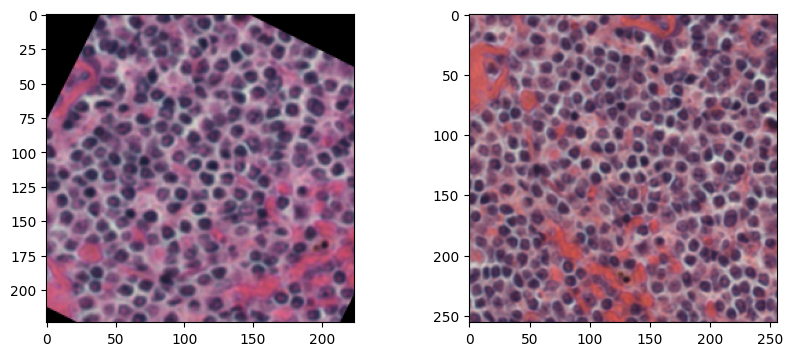

In [ ]:
(images, labels, img_old)=dataset["train"][7]
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(np.moveaxis(images.numpy(),0,-1))
ax[1].imshow(img_old)

print(labels)

In [ ]:
optim = torch.optim.Adam(model.parameters())
nclasses = dataset["train"].classsizes.shape[0]
class_weight=dataset["train"].classsizes
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight)
criterion = nn.CrossEntropyLoss(weight = class_weight)

tensor([0.6700, 0.6000, 0.7300], device='cuda:0')


In [ ]:
#writer = SummaryWriter() # Assuming writer is initialized elsewhere if needed for other logging
best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    all_acc = {key: 0 for key in phases}
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    cmatrix = {key: np.zeros((num_classes,num_classes)) for key in phases}

    for phase in phases:

        if phase == 'train':
            model.train()
        else:
            model.eval()

        for ii , (X, label, img_orig) in enumerate(dataLoader[phase]):
            X = X.to(device)
            label = label.type('torch.LongTensor').to(device)

            with torch.set_grad_enabled(phase == 'train'):
                prediction = model(X)
                loss = criterion(prediction, label)

                # Calculate accuracy for this batch
                _, preds = torch.max(prediction, 1)
                all_acc[phase] += torch.sum(preds == label.data)


                if phase=="train":
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    # train_loss = loss # train_loss variable is not used

                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases:
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))

        # Calculate epoch accuracy
        all_acc[phase] = all_acc[phase].item() / len(dataset[phase])
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        # Log to TensorBoard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        writer.add_scalar(f'{phase}/accuracy', all_acc[phase], epoch)

        if phase in validation_phases:
            # Log confusion matrix components to TensorBoard
            for r in range(nclasses):
                for c in range(nclasses):
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

            # Calculate and log sensitivity and specificity for each class
            for i in range(nclasses):
                TP = cmatrix[phase][i, i]
                # Avoid division by zero if there are no true positives or false positives for a class
                FP = np.sum(cmatrix[phase][i, :]) - TP
                # Avoid division by zero if there are no true positives or false negatives for a class
                FN = np.sum(cmatrix[phase][:, i]) - TP

                # Calculate average sensitivity and specificity across all classes for the epoch summary
                # If np.sum(cmatrix[phase][i, :]) is zero, sensitivity is undefined or 0
                average_sensitivity = cmatrix[phase][i, i] / (np.sum(cmatrix[phase][i, :]) + 1e-9) # Added epsilon to avoid division by zero
                 # If np.sum(cmatrix[phase][:, i]) is zero, specificity is undefined or 0
                average_specificity = (np.sum(cmatrix[phase][:, :]) - np.sum(cmatrix[phase][i, :]) - np.sum(cmatrix[phase][:, i]) + cmatrix[phase][i, i]) / (np.sum(cmatrix[phase][:, :]) - np.sum(cmatrix[phase][i, :]) + 1e-9) # TN / (TN + FP), added epsilon to avoid division by zero


                writer.add_scalar(f'{phase}/sensitivity_{i}', average_sensitivity, epoch)
                writer.add_scalar(f'{phase}/specificity_{i}', average_specificity, epoch)

    # Calculate overall average sensitivity and specificity for the print statement
    overall_sensitivity = np.mean([cmatrix["val"][i, i] / (np.sum(cmatrix["val"][i, :]) + 1e-9) for i in range(nclasses)]) # Added epsilon
    overall_specificity = np.mean([(np.sum(cmatrix["val"][:, :]) - np.sum(cmatrix["val"][i, :]) - np.sum(cmatrix["val"][:, i]) + cmatrix["val"][i, i]) / (np.sum(cmatrix["val"][:, :]) - np.sum(cmatrix["val"][i, :]) + 1e-9) for i in range(nclasses)]) # Added epsilon


    # Modified print statement to include overall sensitivity and specificity in the format tuple
    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f train acc: %.4f test acc: %.4f val sens: %.4f val spec: %.4f' % (
        timeSince(start_time, (epoch+1) / num_epochs),
        epoch+1, num_epochs, (epoch+1) / num_epochs * 100,
        all_loss["train"], all_loss["val"],
        all_acc["train"], all_acc["val"],
        overall_sensitivity, overall_specificity
    ), end="") # removed average_sensitivity, average_specificity as separate args

    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'in_channels': in_channels,
         'growth_rate':growth_rate,
         'block_config':block_config,
         'num_init_features':num_init_features,
         'bn_size':bn_size,
         'drop_rate':drop_rate,
         'num_classes':num_classes}


        torch.save(state, f"/content/drive/MyDrive/lymphoma.tar/{dataname}_densenet_best_model.pth")
    else:
        print("")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


0m 30s (- 50m 55s) ([1/100] 1%), train loss: 0.0762 test loss: 2.7500 train acc: 0.9723 test acc: 0.5367 val sens: 0.5319 val spec: 0.7671  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1m 0s (- 49m 19s) ([2/100] 2%), train loss: 0.0656 test loss: 2.9097 train acc: 0.9770 test acc: 0.6450 val sens: 0.6500 val spec: 0.8206


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1m 29s (- 48m 7s) ([3/100] 3%), train loss: 0.0702 test loss: 2.0462 train acc: 0.9717 test acc: 0.6017 val sens: 0.6292 val spec: 0.8095  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1m 58s (- 47m 26s) ([4/100] 4%), train loss: 0.0699 test loss: 3.6428 train acc: 0.9743 test acc: 0.4950 val sens: 0.5153 val spec: 0.7479


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


2m 29s (- 47m 14s) ([5/100] 5%), train loss: 0.0807 test loss: 2.8789 train acc: 0.9693 test acc: 0.5367 val sens: 0.5694 val spec: 0.7752


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


2m 58s (- 46m 41s) ([6/100] 6%), train loss: 0.0694 test loss: 2.7497 train acc: 0.9720 test acc: 0.6217 val sens: 0.6583 val spec: 0.8206


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


3m 28s (- 46m 4s) ([7/100] 7%), train loss: 0.0580 test loss: 2.6776 train acc: 0.9757 test acc: 0.5267 val sens: 0.5625 val spec: 0.7750


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


3m 57s (- 45m 36s) ([8/100] 8%), train loss: 0.0529 test loss: 3.1319 train acc: 0.9807 test acc: 0.5183 val sens: 0.5014 val spec: 0.7641


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


4m 27s (- 45m 3s) ([9/100] 9%), train loss: 0.0426 test loss: 3.4612 train acc: 0.9847 test acc: 0.5233 val sens: 0.5319 val spec: 0.7736


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


4m 57s (- 44m 36s) ([10/100] 10%), train loss: 0.0752 test loss: 3.8447 train acc: 0.9707 test acc: 0.5167 val sens: 0.5181 val spec: 0.7618


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


5m 27s (- 44m 13s) ([11/100] 11%), train loss: 0.0800 test loss: 6.4668 train acc: 0.9707 test acc: 0.3383 val sens: 0.4347 val spec: 0.7044


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


5m 56s (- 43m 37s) ([12/100] 12%), train loss: 0.0770 test loss: 1.5915 train acc: 0.9707 test acc: 0.6867 val sens: 0.6792 val spec: 0.8447  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


6m 26s (- 43m 3s) ([13/100] 13%), train loss: 0.0539 test loss: 3.4530 train acc: 0.9810 test acc: 0.5233 val sens: 0.5569 val spec: 0.7734


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


6m 55s (- 42m 32s) ([14/100] 14%), train loss: 0.0497 test loss: 2.5481 train acc: 0.9837 test acc: 0.5550 val sens: 0.5292 val spec: 0.7817


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


7m 25s (- 42m 2s) ([15/100] 15%), train loss: 0.0410 test loss: 2.0829 train acc: 0.9857 test acc: 0.6067 val sens: 0.6014 val spec: 0.8025


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


7m 55s (- 41m 38s) ([16/100] 16%), train loss: 0.0541 test loss: 2.1776 train acc: 0.9793 test acc: 0.6500 val sens: 0.6806 val spec: 0.8269


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


8m 25s (- 41m 8s) ([17/100] 17%), train loss: 0.0454 test loss: 2.6389 train acc: 0.9840 test acc: 0.6050 val sens: 0.6347 val spec: 0.8083


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


8m 53s (- 40m 30s) ([18/100] 18%), train loss: 0.0513 test loss: 3.4672 train acc: 0.9800 test acc: 0.6033 val sens: 0.6500 val spec: 0.8148


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


9m 21s (- 39m 54s) ([19/100] 19%), train loss: 0.0601 test loss: 5.4637 train acc: 0.9793 test acc: 0.4300 val sens: 0.4764 val spec: 0.7287


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


9m 51s (- 39m 24s) ([20/100] 20%), train loss: 0.0587 test loss: 3.3268 train acc: 0.9780 test acc: 0.4883 val sens: 0.5139 val spec: 0.7558


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


10m 20s (- 38m 54s) ([21/100] 21%), train loss: 0.0573 test loss: 3.6360 train acc: 0.9780 test acc: 0.4917 val sens: 0.5222 val spec: 0.7525


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


10m 49s (- 38m 21s) ([22/100] 22%), train loss: 0.0698 test loss: 6.3080 train acc: 0.9723 test acc: 0.4950 val sens: 0.5556 val spec: 0.7521


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


11m 18s (- 37m 50s) ([23/100] 23%), train loss: 0.0636 test loss: 4.1285 train acc: 0.9760 test acc: 0.4983 val sens: 0.5222 val spec: 0.7625


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


11m 47s (- 37m 21s) ([24/100] 24%), train loss: 0.0530 test loss: 4.9489 train acc: 0.9807 test acc: 0.4917 val sens: 0.5306 val spec: 0.7560


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


12m 16s (- 36m 49s) ([25/100] 25%), train loss: 0.0541 test loss: 2.5024 train acc: 0.9810 test acc: 0.5700 val sens: 0.5583 val spec: 0.7889


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


12m 45s (- 36m 18s) ([26/100] 26%), train loss: 0.0507 test loss: 3.5492 train acc: 0.9827 test acc: 0.4833 val sens: 0.4458 val spec: 0.7368


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


13m 13s (- 35m 44s) ([27/100] 27%), train loss: 0.0480 test loss: 3.3647 train acc: 0.9807 test acc: 0.5750 val sens: 0.5861 val spec: 0.7965


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


13m 41s (- 35m 13s) ([28/100] 28%), train loss: 0.0471 test loss: 4.0658 train acc: 0.9813 test acc: 0.4733 val sens: 0.5083 val spec: 0.7495


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


14m 10s (- 34m 43s) ([29/100] 28%), train loss: 0.0490 test loss: 3.3352 train acc: 0.9827 test acc: 0.5067 val sens: 0.5014 val spec: 0.7528


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


14m 41s (- 34m 16s) ([30/100] 30%), train loss: 0.0523 test loss: 3.2180 train acc: 0.9803 test acc: 0.5267 val sens: 0.5542 val spec: 0.7639


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


15m 10s (- 33m 46s) ([31/100] 31%), train loss: 0.0587 test loss: 3.3307 train acc: 0.9817 test acc: 0.4717 val sens: 0.4611 val spec: 0.7380


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


15m 39s (- 33m 16s) ([32/100] 32%), train loss: 0.0568 test loss: 3.6069 train acc: 0.9790 test acc: 0.4633 val sens: 0.4986 val spec: 0.7498


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


16m 7s (- 32m 43s) ([33/100] 33%), train loss: 0.0557 test loss: 2.8656 train acc: 0.9793 test acc: 0.6250 val sens: 0.6431 val spec: 0.8153


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


16m 35s (- 32m 11s) ([34/100] 34%), train loss: 0.0676 test loss: 3.3589 train acc: 0.9753 test acc: 0.5067 val sens: 0.5069 val spec: 0.7586


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


17m 3s (- 31m 40s) ([35/100] 35%), train loss: 0.0572 test loss: 3.7470 train acc: 0.9773 test acc: 0.5417 val sens: 0.6097 val spec: 0.7812


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


17m 31s (- 31m 9s) ([36/100] 36%), train loss: 0.0527 test loss: 3.3619 train acc: 0.9780 test acc: 0.5217 val sens: 0.5403 val spec: 0.7694


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


18m 0s (- 30m 39s) ([37/100] 37%), train loss: 0.0615 test loss: 4.0558 train acc: 0.9773 test acc: 0.4683 val sens: 0.4847 val spec: 0.7498


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


18m 29s (- 30m 9s) ([38/100] 38%), train loss: 0.0581 test loss: 2.7764 train acc: 0.9807 test acc: 0.6117 val sens: 0.6569 val spec: 0.8130


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


18m 58s (- 29m 40s) ([39/100] 39%), train loss: 0.0721 test loss: 4.0080 train acc: 0.9723 test acc: 0.5117 val sens: 0.5417 val spec: 0.7569


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


19m 27s (- 29m 10s) ([40/100] 40%), train loss: 0.0546 test loss: 3.2129 train acc: 0.9767 test acc: 0.6200 val sens: 0.6681 val spec: 0.8201


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


19m 57s (- 28m 43s) ([41/100] 41%), train loss: 0.0461 test loss: 4.4553 train acc: 0.9827 test acc: 0.4133 val sens: 0.4444 val spec: 0.7137


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


20m 26s (- 28m 13s) ([42/100] 42%), train loss: 0.0532 test loss: 5.2182 train acc: 0.9790 test acc: 0.4467 val sens: 0.5208 val spec: 0.7428


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


20m 53s (- 27m 42s) ([43/100] 43%), train loss: 0.0465 test loss: 2.5826 train acc: 0.9830 test acc: 0.5083 val sens: 0.4847 val spec: 0.7414


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


21m 21s (- 27m 10s) ([44/100] 44%), train loss: 0.0502 test loss: 2.5694 train acc: 0.9783 test acc: 0.6250 val sens: 0.6194 val spec: 0.8148


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


21m 48s (- 26m 39s) ([45/100] 45%), train loss: 0.0497 test loss: 3.9067 train acc: 0.9820 test acc: 0.5517 val sens: 0.5986 val spec: 0.7889


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


22m 16s (- 26m 8s) ([46/100] 46%), train loss: 0.0644 test loss: 3.1621 train acc: 0.9790 test acc: 0.5217 val sens: 0.4972 val spec: 0.7611


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


22m 44s (- 25m 38s) ([47/100] 47%), train loss: 0.0411 test loss: 2.8672 train acc: 0.9867 test acc: 0.6083 val sens: 0.6181 val spec: 0.8086


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


23m 12s (- 25m 8s) ([48/100] 48%), train loss: 0.0311 test loss: 4.4682 train acc: 0.9887 test acc: 0.4350 val sens: 0.4736 val spec: 0.7324


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


23m 41s (- 24m 39s) ([49/100] 49%), train loss: 0.0384 test loss: 2.9505 train acc: 0.9887 test acc: 0.6000 val sens: 0.6403 val spec: 0.8106


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


24m 9s (- 24m 9s) ([50/100] 50%), train loss: 0.0425 test loss: 3.9882 train acc: 0.9820 test acc: 0.5517 val sens: 0.6153 val spec: 0.7896


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


24m 37s (- 23m 39s) ([51/100] 51%), train loss: 0.0492 test loss: 2.9292 train acc: 0.9830 test acc: 0.5750 val sens: 0.6042 val spec: 0.7954


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


25m 6s (- 23m 10s) ([52/100] 52%), train loss: 0.0360 test loss: 3.8969 train acc: 0.9853 test acc: 0.5767 val sens: 0.6417 val spec: 0.8000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


25m 35s (- 22m 42s) ([53/100] 53%), train loss: 0.0337 test loss: 2.7573 train acc: 0.9893 test acc: 0.6000 val sens: 0.6208 val spec: 0.8113


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


26m 5s (- 22m 13s) ([54/100] 54%), train loss: 0.0466 test loss: 6.4764 train acc: 0.9840 test acc: 0.4517 val sens: 0.4958 val spec: 0.7282


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


26m 32s (- 21m 43s) ([55/100] 55%), train loss: 0.0429 test loss: 2.8930 train acc: 0.9847 test acc: 0.5317 val sens: 0.5069 val spec: 0.7669


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


27m 0s (- 21m 12s) ([56/100] 56%), train loss: 0.0525 test loss: 1.6173 train acc: 0.9820 test acc: 0.6600 val sens: 0.7111 val spec: 0.8437


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


27m 27s (- 20m 43s) ([57/100] 56%), train loss: 0.0477 test loss: 4.6597 train acc: 0.9820 test acc: 0.5550 val sens: 0.6069 val spec: 0.7769


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


27m 55s (- 20m 12s) ([58/100] 57%), train loss: 0.0384 test loss: 4.6864 train acc: 0.9853 test acc: 0.3783 val sens: 0.4014 val spec: 0.6984


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


28m 23s (- 19m 43s) ([59/100] 59%), train loss: 0.0422 test loss: 2.9761 train acc: 0.9853 test acc: 0.6017 val sens: 0.6333 val spec: 0.8095


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


28m 52s (- 19m 14s) ([60/100] 60%), train loss: 0.0358 test loss: 3.0466 train acc: 0.9863 test acc: 0.5367 val sens: 0.5208 val spec: 0.7660


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


29m 20s (- 18m 45s) ([61/100] 61%), train loss: 0.0360 test loss: 4.0085 train acc: 0.9840 test acc: 0.4583 val sens: 0.4514 val spec: 0.7322


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


29m 49s (- 18m 16s) ([62/100] 62%), train loss: 0.0495 test loss: 2.3234 train acc: 0.9837 test acc: 0.6467 val sens: 0.6667 val spec: 0.8340


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


30m 17s (- 17m 47s) ([63/100] 63%), train loss: 0.0430 test loss: 3.3358 train acc: 0.9857 test acc: 0.4817 val sens: 0.4528 val spec: 0.7449


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


30m 46s (- 17m 18s) ([64/100] 64%), train loss: 0.0484 test loss: 3.4283 train acc: 0.9810 test acc: 0.5633 val sens: 0.6014 val spec: 0.7891


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


31m 14s (- 16m 49s) ([65/100] 65%), train loss: 0.0531 test loss: 3.2633 train acc: 0.9810 test acc: 0.4417 val sens: 0.4486 val spec: 0.7231


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


31m 43s (- 16m 20s) ([66/100] 66%), train loss: 0.0501 test loss: 5.4686 train acc: 0.9817 test acc: 0.4033 val sens: 0.3361 val spec: 0.6924


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


32m 10s (- 15m 50s) ([67/100] 67%), train loss: 0.0570 test loss: 3.7995 train acc: 0.9783 test acc: 0.5550 val sens: 0.5306 val spec: 0.7778


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


32m 39s (- 15m 21s) ([68/100] 68%), train loss: 0.0577 test loss: 4.8119 train acc: 0.9777 test acc: 0.4550 val sens: 0.4806 val spec: 0.7412


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


33m 7s (- 14m 53s) ([69/100] 69%), train loss: 0.0507 test loss: 4.9251 train acc: 0.9800 test acc: 0.4500 val sens: 0.4472 val spec: 0.7368


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


33m 36s (- 14m 23s) ([70/100] 70%), train loss: 0.0367 test loss: 2.6721 train acc: 0.9850 test acc: 0.5833 val sens: 0.6111 val spec: 0.7917


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


34m 4s (- 13m 54s) ([71/100] 71%), train loss: 0.0538 test loss: 3.5343 train acc: 0.9770 test acc: 0.6283 val sens: 0.6431 val spec: 0.8215


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


34m 32s (- 13m 26s) ([72/100] 72%), train loss: 0.0444 test loss: 4.1855 train acc: 0.9857 test acc: 0.5550 val sens: 0.5681 val spec: 0.7808


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


35m 1s (- 12m 57s) ([73/100] 73%), train loss: 0.0416 test loss: 2.8851 train acc: 0.9840 test acc: 0.6083 val sens: 0.6236 val spec: 0.8106


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


35m 30s (- 12m 28s) ([74/100] 74%), train loss: 0.0434 test loss: 4.4071 train acc: 0.9837 test acc: 0.4183 val sens: 0.4000 val spec: 0.7037


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


35m 59s (- 11m 59s) ([75/100] 75%), train loss: 0.0282 test loss: 2.0644 train acc: 0.9903 test acc: 0.6783 val sens: 0.7028 val spec: 0.8458


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


36m 27s (- 11m 30s) ([76/100] 76%), train loss: 0.0359 test loss: 3.7404 train acc: 0.9917 test acc: 0.6133 val sens: 0.6389 val spec: 0.8162


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


36m 54s (- 11m 1s) ([77/100] 77%), train loss: 0.0589 test loss: 4.1230 train acc: 0.9780 test acc: 0.5417 val sens: 0.5694 val spec: 0.7725


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


37m 22s (- 10m 32s) ([78/100] 78%), train loss: 0.0493 test loss: 5.8004 train acc: 0.9820 test acc: 0.3850 val sens: 0.4667 val spec: 0.7273


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


37m 50s (- 10m 3s) ([79/100] 79%), train loss: 0.0492 test loss: 3.2191 train acc: 0.9813 test acc: 0.4950 val sens: 0.5125 val spec: 0.7546


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


38m 18s (- 9m 34s) ([80/100] 80%), train loss: 0.0451 test loss: 2.4537 train acc: 0.9847 test acc: 0.6350 val sens: 0.6472 val spec: 0.8201


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


38m 47s (- 9m 5s) ([81/100] 81%), train loss: 0.0355 test loss: 3.8722 train acc: 0.9867 test acc: 0.4483 val sens: 0.4167 val spec: 0.7164


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


39m 15s (- 8m 36s) ([82/100] 82%), train loss: 0.0249 test loss: 4.0891 train acc: 0.9917 test acc: 0.6583 val sens: 0.6958 val spec: 0.8359


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


39m 42s (- 8m 8s) ([83/100] 83%), train loss: 0.0232 test loss: 2.6627 train acc: 0.9917 test acc: 0.5983 val sens: 0.6264 val spec: 0.8023


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


40m 10s (- 7m 39s) ([84/100] 84%), train loss: 0.0294 test loss: 2.5577 train acc: 0.9880 test acc: 0.5517 val sens: 0.5444 val spec: 0.7787


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


40m 38s (- 7m 10s) ([85/100] 85%), train loss: 0.0352 test loss: 6.2787 train acc: 0.9883 test acc: 0.4817 val sens: 0.5667 val spec: 0.7579


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


41m 7s (- 6m 41s) ([86/100] 86%), train loss: 0.0703 test loss: 4.2106 train acc: 0.9740 test acc: 0.4000 val sens: 0.4069 val spec: 0.7030


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


41m 36s (- 6m 13s) ([87/100] 87%), train loss: 0.0533 test loss: 3.5916 train acc: 0.9800 test acc: 0.5417 val sens: 0.5528 val spec: 0.7822


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


42m 5s (- 5m 44s) ([88/100] 88%), train loss: 0.0352 test loss: 4.8052 train acc: 0.9883 test acc: 0.4433 val sens: 0.4583 val spec: 0.7285


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


42m 32s (- 5m 15s) ([89/100] 89%), train loss: 0.0335 test loss: 3.6060 train acc: 0.9877 test acc: 0.5333 val sens: 0.5681 val spec: 0.7838


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


42m 59s (- 4m 46s) ([90/100] 90%), train loss: 0.0304 test loss: 3.3667 train acc: 0.9870 test acc: 0.5333 val sens: 0.5319 val spec: 0.7699


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


43m 27s (- 4m 17s) ([91/100] 91%), train loss: 0.0274 test loss: 3.9757 train acc: 0.9900 test acc: 0.5717 val sens: 0.6236 val spec: 0.8032


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


43m 54s (- 3m 49s) ([92/100] 92%), train loss: 0.0369 test loss: 2.7932 train acc: 0.9863 test acc: 0.5317 val sens: 0.5417 val spec: 0.7780


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


44m 21s (- 3m 20s) ([93/100] 93%), train loss: 0.0289 test loss: 2.3130 train acc: 0.9893 test acc: 0.6150 val sens: 0.6486 val spec: 0.8181


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


44m 57s (- 2m 52s) ([94/100] 94%), train loss: 0.0294 test loss: 3.8369 train acc: 0.9907 test acc: 0.5550 val sens: 0.5389 val spec: 0.7750


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


45m 25s (- 2m 23s) ([95/100] 95%), train loss: 0.0456 test loss: 4.9383 train acc: 0.9823 test acc: 0.5350 val sens: 0.5931 val spec: 0.7725


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


45m 53s (- 1m 54s) ([96/100] 96%), train loss: 0.0433 test loss: 2.5692 train acc: 0.9837 test acc: 0.6333 val sens: 0.6444 val spec: 0.8220


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


46m 21s (- 1m 25s) ([97/100] 97%), train loss: 0.0534 test loss: 5.1036 train acc: 0.9810 test acc: 0.4050 val sens: 0.4528 val spec: 0.7245


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


46m 47s (- 0m 57s) ([98/100] 98%), train loss: 0.0640 test loss: 2.7071 train acc: 0.9767 test acc: 0.6067 val sens: 0.6417 val spec: 0.8148


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


47m 15s (- 0m 28s) ([99/100] 99%), train loss: 0.0549 test loss: 2.5517 train acc: 0.9767 test acc: 0.4850 val sens: 0.4611 val spec: 0.7398


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


47m 43s (- -1m 59s) ([100/100] 100%), train loss: 0.0292 test loss: 5.1064 train acc: 0.9880 test acc: 0.5650 val sens: 0.6042 val spec: 0.7859
